# Explore PACE BIC values

In [1]:
# imports
from importlib import reload
from importlib.resources import files
import os
import numpy as np

from scipy.optimize import curve_fit

import pandas
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.interpolate import interp1d

from oceancolor.hydrolight import loisel23
from oceancolor.utils import plotting as oc_plotting

from big.models import anw as big_anw
from big.models import bbnw as big_bbnw
from big import inference as big_inf
from big import rt as big_rt
from big import chisq_fit

import anly_utils

In [2]:
%matplotlib ipympl

# Load

## L23

In [3]:
ds = loisel23.load_ds(4,0)

### Unpack

In [4]:
l23_wave = ds.Lambda.data
l23_Rrs = ds.Rrs.data
a = ds.a.data
bb = ds.bb.data
adg = ds.ag.data + ds.ad.data
aph = ds.aph.data
anw = ds.anw.data

## Fits

In [5]:
ks = [3,4,5]
pdict = {}
for k in ks:
    pdict[k] = {}
    # Model names
    if k == 3:
        model_names = ['Exp', 'Cst']
    elif k == 4:
        model_names = ['Exp', 'Pow']
    elif k == 5:
        model_names = ['ExpBricaud', 'Pow']
    else:
        raise ValueError("Bad k")

    chain_file, noises, noise_lbl = anly_utils.get_chain_file(
        model_names, 0.02, False, 'L23', use_LM=True,
        PACE=True)
    # Load up
    d = np.load(chain_file)
    # Parse
    pdict[k]['params'] = d['ans']
    if k == ks[0]:
        pdict['Rrs'] = d['obs_Rrs']
        pdict['idx'] = d['idx']
    #import pdb; pdb.set_trace()

In [6]:
pdict[4]['params'].shape

(3320, 4)

# Calc ICs

In [7]:
s2ns = [0.05, 0.10, 0.2, 'PACE']

Adict, Bdict = anly_utils.calc_ICs(
    ks, s2ns, use_LM=True, PACE=True)

Loaded: ../Analysis/Fits/BIG_LM_ExpCst_P23_n02.npz
Loaded: ../Analysis/Fits/BIG_LM_ExpPow_P23_n02.npz
Loaded: ../Analysis/Fits/BIG_LM_ExpBricaudPow_P23_n02.npz


In [8]:
Bdict[4].shape

(4, 3320)

## $\Delta \, \rm BIC$

In [9]:
D_BIC_34 = Bdict[3] - Bdict[4]
D_BIC_45 = Bdict[4] - Bdict[5]

D_BIC_34 = np.maximum(D_BIC_34, -5.)
D_BIC_45 = np.maximum(D_BIC_45, -5.)

In [10]:
D_BIC_45.shape

(4, 3320)

# Plots

## $\Delta \, \rm BIC_{45}$

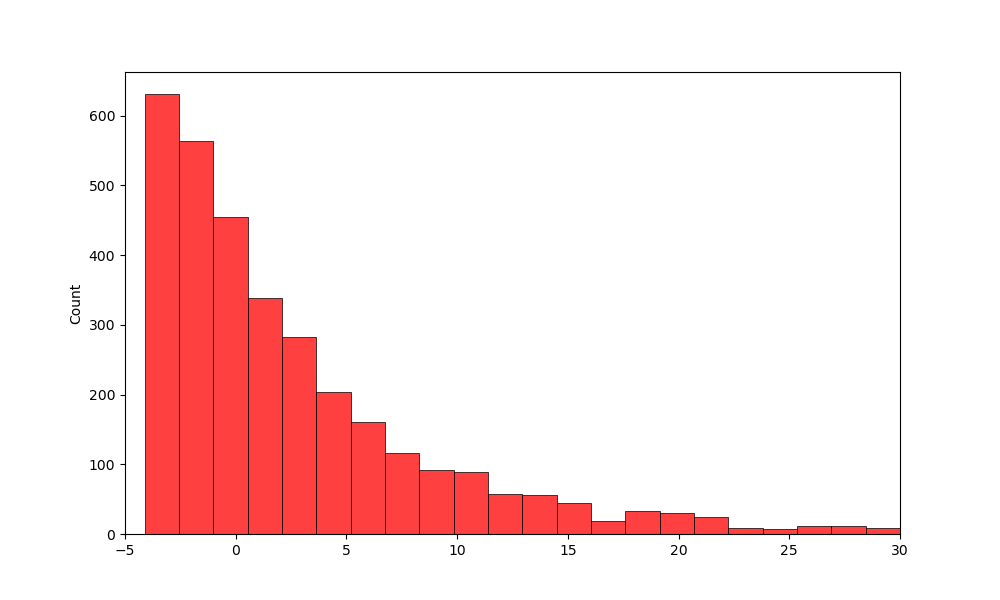

In [16]:
fig = plt.figure(figsize=(10,6))
ax = plt.gca()
#
_ = sns.histplot(x=D_BIC_45[-1,:], ax=ax, color='red', bins=100)
ax.set_xlim(-5., 30.)
#
plt.show()

## $\Delta \, \rm BIC$ vs. $a_{\rm ph}/a$

In [17]:
DBIC_PACE = D_BIC_45[-1,:]

In [18]:
i440 = np.argmin(np.abs(l23_wave-440.))
aph_anw = aph[:,i440]/anw[:,i440]

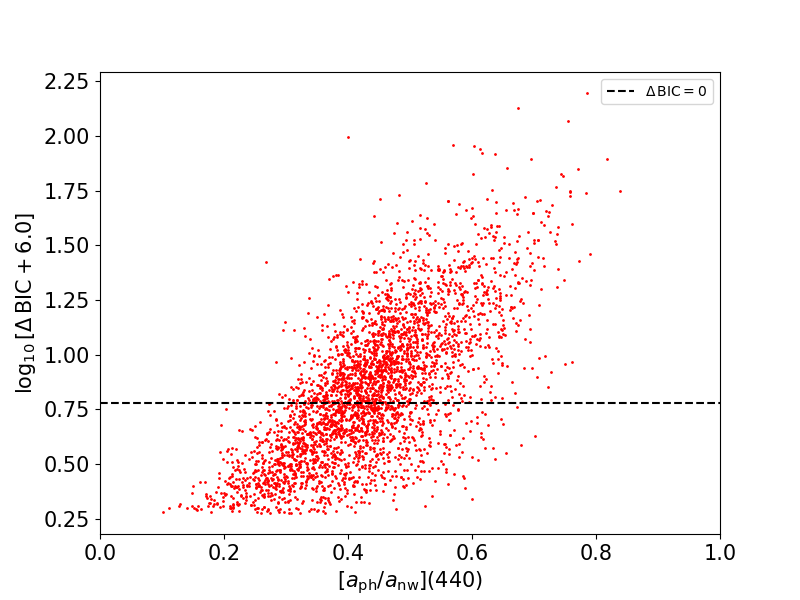

In [28]:
xmin, xmax = 0.0, 1.0
yoff = 6.
#
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
#
ax.scatter(aph_anw, np.log10(DBIC_PACE+yoff), s=1, color='red')
ax.axhline(np.log10(yoff), color='k', ls='--', label=r'$\Delta \, \rm BIC = 0$')
# Sg
#ax.fill_between([xmin, xmax], [np.log10(0.01)]*2, [np.log10(0.02)]*2, color='cyan', alpha=0.3, label=r'$S_g$')
#
ax.set_ylabel(r'$\log_{10} [\Delta \, \rm BIC + '+f'{yoff}'+']$')
ax.set_xlabel(r'$[a_{\rm ph}/a_{\rm nw}] (440)$')
ax.set_xlim(xmin, xmax)
#
#ax.set_ylim(-3., None)
ax.legend()
#
oc_plotting.set_fontsize(ax, 15.)
plt.show()